In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from math import sqrt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
import shap

## Data preparation

In [2]:
df = pd.read_csv('dataset_fchl\no_corr_fchl_122_dataset.csv',  dtype={'Complex ID': 'str'})
df

,Complex ID,1,2,3,4,5,6,7,8,9,...,Charge,Shift,Dipole_point_q,q,Brutto,Charge_class,Geometry,Ligand,Smiles,Source_doi
0,4,2.33,17.0,0.0101,2.33000,-0.04390,2.33,17.0,-0.0106,-2.330,...,-2000,-1630,16.713013,91.0,[PtCl4]2-,anion,sq-pl,hal,Cl[Pt@SP1](Cl)(Cl)Cl,https://doi.org/10.1002/ejic.201600573
1,5,2.34,17.0,2.3400,0.00314,0.00906,2.34,17.0,0.0581,2.340,...,-2000,-1842,770.758366,56.0,[PtCl3Br]2-,anion,sq-pl,hal,Cl[Pt@SP1](Cl)(Cl)Br,https://doi.org/10.1002/ejic.201600573
2,6,2.36,17.0,2.2300,0.59600,-0.46300,2.36,17.0,-2.2300,-0.596,...,0,-2090,0.254180,26.0,trans-[PtCl2Br2],neutral,sq-pl,hal,Br[Pt@SP1](Cl)(Br)Cl,https://doi.org/10.1002/ejic.201600573
3,7,2.35,17.0,2.3200,0.19000,0.30800,2.35,17.0,0.3060,-2.330,...,0,-2103,1003.165338,18.0,cis-[PtCl2Br2],neutral,sq-pl,hal,Cl[Pt@SP1](Cl)(Br)[Br],https://doi.org/10.1002/ejic.201600573
4,8,2.32,17.0,2.3200,-0.01040,0.00478,2.35,17.0,0.1010,2.350,...,-2000,-2346,1414.192862,-6.0,[PtCl3I]2-,anion,sq-pl,hal,Cl[Pt@SP1](Cl)(Cl)I,https://doi.org/10.1002/ejic.201600573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,545,2.07,7.0,2.0500,-0.21200,-0.17800,2.07,7.0,-2.0500,0.212,...,0,-3372,2.934876,-191.0,trans-[Pt(NH3)2I2],neutral,sq-pl,hal-org,[Pt@SP1]([NH3+])(I)([NH3+])I,https://doi.org/10.1002/ejic.202000474
118,546,2.16,7.0,-2.1500,-0.22900,0.05290,2.18,17.0,2.1700,0.232,...,-1000,-1884,1282.595422,219.0,[Pt(NH3)Cl3]-,anion,sq-pl,hal-org,[Pt@SP1]([NH3+])(Cl)(Cl)Cl,https://doi.org/10.1002/ejic.202000474
119,547,1.90,7.0,-1.8700,0.07830,0.28500,2.34,35.0,0.4750,-1.940,...,-1000,-2534,598.143687,185.0,[Pt(NH3)Br3]-,anion,sq-pl,hal-org,[Pt@SP1]([NH3+])(Br)(Br)Br,https://doi.org/10.1002/ejic.202000474
120,548,2.19,17.0,-0.2590,-1.00000,1.93000,2.22,7.0,0.2800,1.010,...,-1000,-3298,1269.126886,55.0,trans-[Pt(NH3)ClI2]-,anion,sq-pl,hal-org,[Pt@SP1]([NH3+])(I)(Cl)I,https://doi.org/10.1002/ejic.202000474


In [3]:
y = df.Shift.to_numpy()
X = df.drop(['Complex ID', 'Shift', 'Source_doi', 'Brutto', 'Charge_class', 'Geometry', 'Ligand', 'Smiles'], axis=1)
columns = X.columns
X = X.to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler_train = StandardScaler()

scaler_train.fit(X_train)
scaler_train.fit(X_test)

X_train_norm = scaler_train.transform(X_train)
X_test_norm = scaler_train.transform(X_test)

## Some useful functions

In [6]:
def metrics(y, y_pred):
    
    rmse = sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('RMSE = {:0.2f} ppm'.format(rmse),'\n',
          'MAE = {:0.2f} ppm'.format(mae), '\n',
         '$R^2$ = {:0.2f}'.format(r2))   
    
    return {'RMSE': rmse, 'MAE': mae, '$R^2$': r2}

In [7]:
def plot_correlation(model, X, y):
    
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(figsize=(8,8))
    plt.plot(y, y, color='r', linestyle='-', linewidth=2)
    plt.plot(y, model.predict(X), linestyle='none', color='blue', marker='o')
    
    plt.xlabel("Experimental δ, ppm")
    plt.ylabel("Predicted δ, ppm")
    fig.tight_layout() 
    plt.show()
    fig.savefig('fchl_{}.png'.format(str(model)[:10]), dpi=300, bbox_inches = 'tight')
    
    return metrics(y, model.predict(X))

In [8]:
def tune_hyperparam(estimator, grid, X, y):
    
    est_random = RandomizedSearchCV(estimator=estimator, param_distributions = grid, n_iter = 100, 
                                    cv = 5, verbose=2, random_state=42, n_jobs = -1)
    est_random.fit(X, y)
    print(est_random.best_params_)
    print('Mean of $R**2$', est_random.best_score_)
    
    return est_random.best_estimator_

In [9]:
def evaluate(estimator, X, y, n_splits, scoring):
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    
    if scoring == 'r2':
        scores = scores
        
    if scoring == 'neg_mean_absolute_error':
        scores = [-i for i in scores]
        
    if scoring == 'neg_mean_squared_error':
        scores = [np.sqrt(-i) for i in scores]
        
    return {'Mean':np.round(np.mean(scores), 2), 'Std': np.round(np.std(scores), 2),
            'Min': np.round(np.min(scores), 2), 'Max': np.round(np.max(scores), 2)}

## Models: Random Forest, Ridge regressor, SVR

### Hyperprameter tuning by use of grid search

In [10]:
#Random forest grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 205, num = 22)]
max_depth.append(None)
min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
warm_start = [True, False]
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'warm_start': warm_start}

In [11]:
#Ridge regression grid
alpha = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
coef0 = np.linspace(1.e-10, 1, 50)
degree = [0, 1, 2, 3, 4]
gamma = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
kernel = ['laplacian', 'RBF', 'polynomial', 'exponential chi2', 'sigmoid']

grid_ridge = {'alpha': alpha,
         'coef0': coef0,
         'degree': degree,
         'gamma': gamma,
         'kernel': kernel}

In [12]:
#SVR grid
C = [10000, 100000, 1000000, 10000000]
coef0 = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
degree = [1, 2, 3, 4, 5]
epsilon = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
gamma = ['scale', 'auto']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
tol = [1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
max_iter = 1000000

grid_svr = {'C' : C,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'tol': tol}

In [13]:
rf = RandomForestRegressor(random_state=42)
ridge = KernelRidge()
svr = SVR(max_iter=max_iter)
estimators = {rf: grid_rf, ridge: grid_ridge, svr: grid_svr}

In [14]:
best_estim = []
for i, j in estimators.items():
    best_estim.append(tune_hyperparam(i, j, X_train_norm, y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits



40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File 

{'warm_start': False, 'n_estimators': 322, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 14, 'bootstrap': False}
Mean of $R**2$ 0.8834684591672881
Fitting 5 folds for each of 100 candidates, totalling 500 fits



185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\kernel_ridge.py", line 186, in fit
    K = self._get_kernel(X)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\kernel_ridge.py", line 154, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py", lin

{'kernel': 'laplacian', 'gamma': 0.001, 'degree': 4, 'coef0': 0.020408163363265307, 'alpha': 1e-08}
Mean of $R**2$ 0.9083244338575319
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'tol': 1e-07, 'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.01, 'degree': 2, 'coef0': 1e-05, 'C': 10000000}
Mean of $R**2$ 0.8520337326635439


In [15]:
best_estim

[RandomForestRegressor(bootstrap=False, max_depth=14, max_features='auto',
                       min_samples_leaf=2, min_samples_split=5, n_estimators=322,
                       random_state=42),
 KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
             kernel='laplacian'),
 SVR(C=10000000, coef0=1e-05, degree=2, epsilon=0.01, max_iter=1000000,
     tol=1e-07)]

### Training and evaluation of models by use of cross-validation

In [16]:
print('Range of chem shifts', np.min(y_train), ':', np.max(y_train))

Range of chem shifts -6293 : 7090


In [17]:
#Determination coefficient
res_r2 = []
for i in best_estim:
    res_r2.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='r2'))
res_df_r2 = pd.DataFrame(res_r2, index=['RF', 'Ridge regr', 'SVR'])
res_df_r2

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,Mean,Std,Min,Max
RF,0.89,0.06,0.79,0.97
Ridge regr,0.92,0.04,0.86,0.97
SVR,0.93,0.03,0.87,0.96


In [18]:
#MAE
res_mae = []
for i in best_estim:
    res_mae.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_absolute_error'))
res_df_mae = pd.DataFrame(res_mae, index=['RF', 'Ridge regr', 'SVR'])
res_df_mae

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,Mean,Std,Min,Max
RF,501.11,70.20,402.69,600.79
Ridge regr,434.34,40.21,383.43,483.87
SVR,456.35,38.22,411.20,506.81


In [19]:
#RMSE
res_rmse = []
for i in best_estim:
    res_rmse.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_squared_error'))
res_df_rmse = pd.DataFrame(res_rmse, index=['RF', 'Ridge regr', 'SVR'])
res_df_rmse

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


,Mean,Std,Min,Max
RF,692.53,124.94,515.50,867.38
Ridge regr,583.65,117.41,479.63,782.24
SVR,582.11,55.23,527.90,663.97


RandomForestRegressor(bootstrap=False, max_depth=14, max_features='auto',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=322,
                      random_state=42)


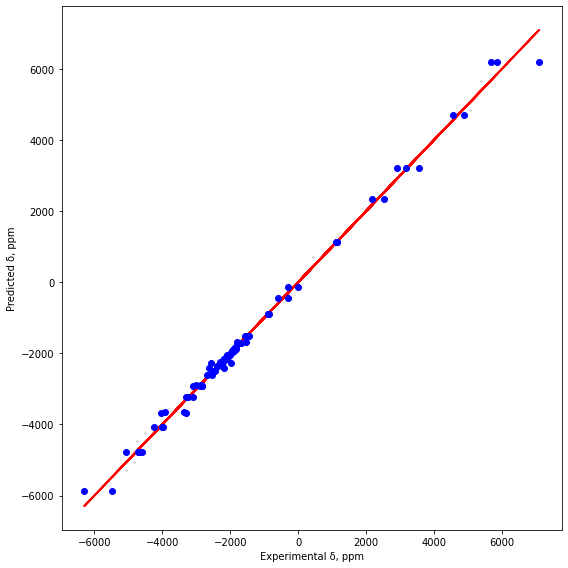

RMSE = 175.24 ppm 
 MAE = 103.80 ppm 
 $R^2$ = 0.99


KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
            kernel='laplacian')


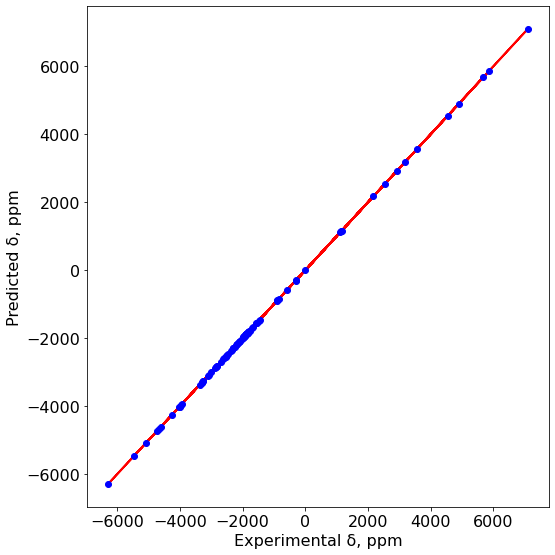

RMSE = 0.00 ppm 
 MAE = 0.00 ppm 
 $R^2$ = 1.00


SVR(C=10000000, coef0=1e-05, degree=2, epsilon=0.01, max_iter=1000000,
    tol=1e-07)


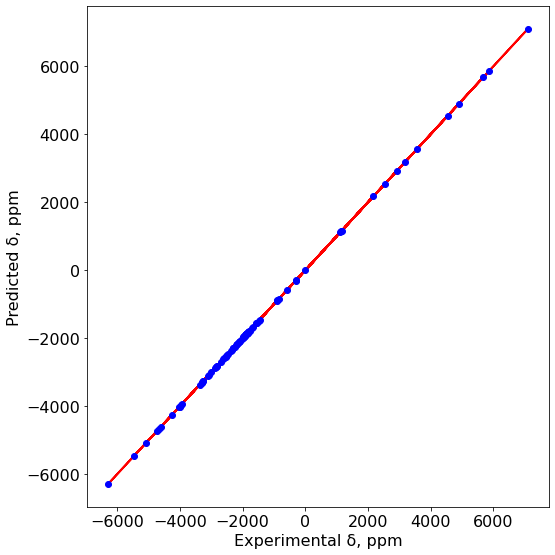

RMSE = 0.03 ppm 
 MAE = 0.02 ppm 
 $R^2$ = 1.00




In [20]:
for i in best_estim:
    print(i)
    plot_correlation(i, X_train_norm, y_train,)
    print('\n')

RandomForestRegressor(bootstrap=False, max_depth=14, max_features='auto',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=322,
                      random_state=42)


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

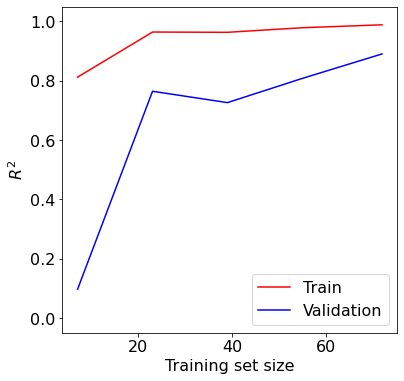

KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
            kernel='laplacian')


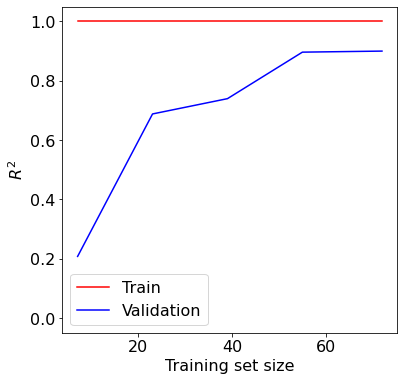

SVR(C=10000000, coef0=1e-05, degree=2, epsilon=0.01, max_iter=1000000,
    tol=1e-07)


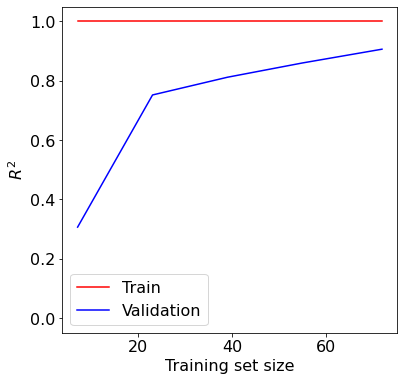

In [21]:
#Learning curves train vs. validation
for i in best_estim:
    print(i)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(i, X_train_norm, y_train, cv=4,return_times=True, scoring='r2')
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(train_sizes,np.mean(train_scores,axis=1), color='r', label='Train')
    plt.plot(train_sizes,np.mean(test_scores,axis=1), color='blue', label='Validation')
    plt.ylabel('$R^2$')
    plt.xlabel('Training set size')
    plt.ylim(-0.05,1.05)
    plt.legend()
    plt.show()
    fig.savefig('fchl_learning curve {}.png'.format(str(i)[:10]), dpi=300, bbox_inches = 'tight')



## Test the model on held-out data

RandomForestRegressor(bootstrap=False, max_depth=14, max_features='auto',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=322,
                      random_state=42)


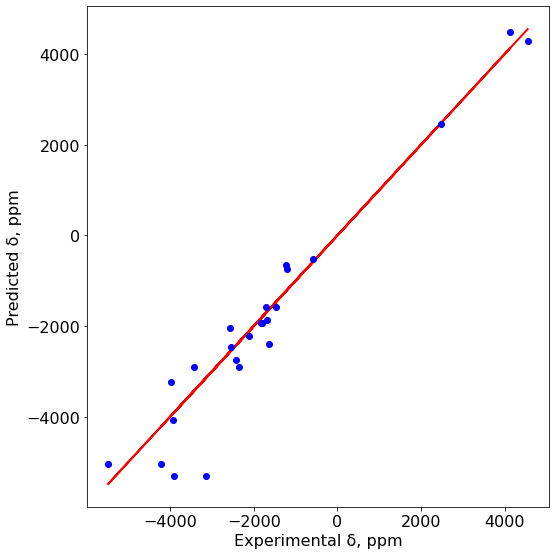

RMSE = 652.52 ppm 
 MAE = 447.12 ppm 
 $R^2$ = 0.92


KernelRidge(alpha=1e-08, coef0=0.020408163363265307, degree=4, gamma=0.001,
            kernel='laplacian')


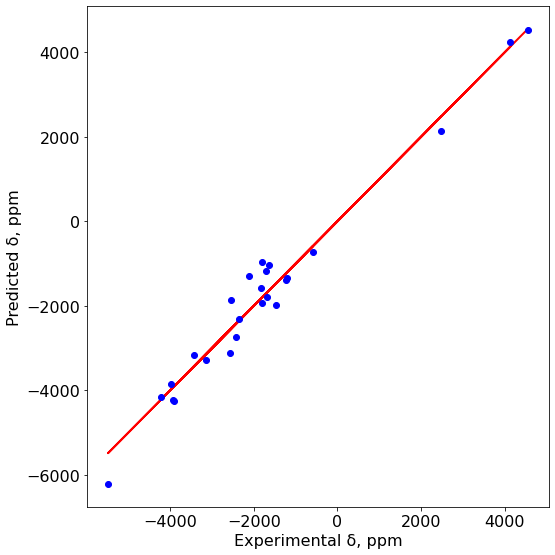

RMSE = 411.25 ppm 
 MAE = 328.07 ppm 
 $R^2$ = 0.97


SVR(C=10000000, coef0=1e-05, degree=2, epsilon=0.01, max_iter=1000000,
    tol=1e-07)


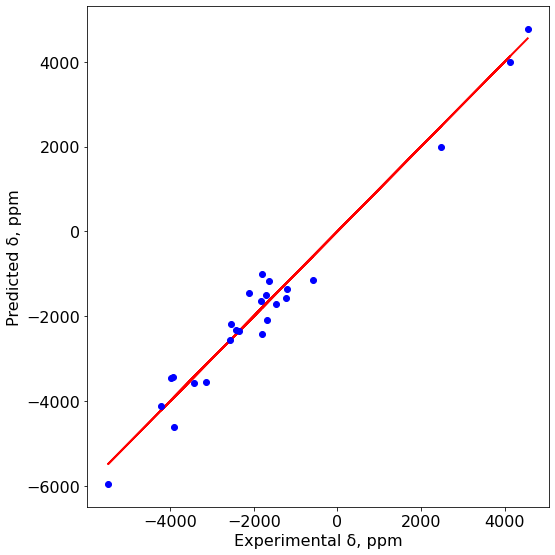

RMSE = 417.41 ppm 
 MAE = 354.51 ppm 
 $R^2$ = 0.97




In [22]:
for i in best_estim:
    print(i)
    plot_correlation(i, X_test_norm, y_test)
    print('\n')

## Models explanation

In [ ]:
shap.initjs()
columns

### Random Forest

In [ ]:
explainer_rf = shap.TreeExplainer(model=best_estim[0])
shap_values_rf = explainer_rf.shap_values(X_train_norm[0])

shap.force_plot(base_value=explainer_rf.expected_value, shap_values=shap_values_rf,
                features=X_train_norm[0], feature_names=columns)

In [ ]:
explainer_rf = shap.TreeExplainer(model=best_estim[0])
shap_values_rf = explainer_rf(X_train_norm)
shap.summary_plot(shap_values_rf, X_train_norm, feature_names=columns, show=False)
plt.savefig('shap_random_forest.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Laplacian kernel ridge regression

In [ ]:
explainer_ridge = shap.KernelExplainer(model=best_estim[1].predict, data=X_train_norm)
shap_values_ridge = explainer_ridge.shap_values(X_test_norm[0])

shap.force_plot(base_value=explainer_ridge.expected_value, shap_values=shap_values_ridge,
                features=X_test_norm[0], feature_names=columns)

In [ ]:
shap_values_ridge = explainer_ridge.shap_values(X_train_norm)
shap.summary_plot(shap_values_ridge, X_train_norm, feature_names = columns, show=False)
plt.savefig('shap_kernel.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### SVR

In [ ]:
explainer_svr = shap.KernelExplainer(model=best_estim[2].predict, data=X_train_norm)
shap_values_svr = explainer_svr.shap_values(X_train_norm[0])

shap.force_plot(base_value=explainer_svr.expected_value, shap_values=shap_values_svr,
                features=X_train_norm[0], feature_names=columns)

In [ ]:
shap_values_svr = explainer_svr.shap_values(X_train_norm)
shap.summary_plot(shap_values_svr, X_train_norm, feature_names = columns, show=False)
plt.savefig('shap_svr.png', format='png', dpi=600, bbox_inches='tight')
plt.show()